In [51]:
# import stuffs
%matplotlib inline
import numpy as np
import pandas as pd
from pyplotthemes import get_savefig, ClassicTheme
#plt.latex = True
# Set to PLOS One requirements
pltkwargs = {'text.usetex': True,
            'text.latex.unicode': True,
            #'font.family': 'sans-serif',
            'font.sans-serif': 'Arial',
            'font.serif': 'Times'}
plt = ClassicTheme(**pltkwargs)
savefig = get_savefig('../fig', extensions=['pdf', 'eps'])

In [2]:
from datasets import get_colon, get_nwtco, get_flchain, get_pbc, get_lung

# Training data
datasets = {}

# Add the data sets
for name, getter in zip(["pbc", "lung", "colon", "nwtco", "flchain"],
                         [get_pbc, get_lung, get_colon, get_nwtco, get_flchain]):
    trn = getter(norm_in=True, norm_out=False, training=True)
    datasets[name] = trn
    
    cens = (trn.iloc[:, 1] == 0)
    censcount = np.sum(cens) / trn.shape[0]
    print(name, "censed:", censcount)
    

# Crossval variables
cross_n = 10
cross_k = 3

pbc censed: 0.608163265306
lung censed: 0.27485380117
colon censed: 0.495689655172
nwtco censed: 0.857994041708
flchain censed: 0.724716245977


In [3]:
from pysurvival.rpart import RPartModel

# Save predictions for later
rpart_val_preds = {}
for dname in datasets.keys():
    # N lists : Each k items later
    rpart_val_preds[dname] = [[] for _ in range(cross_n)]
    

# Default values in rpart actually
rpart_kwargs = dict(highlim=0.15,
                    lowlim=0.15,
                    minsplit=20,
                    minbucket=None,
                    xval=3,
                    cp=0.01)

# Networks depend on rparts training values
rpart = RPartModel(**rpart_kwargs)

In [4]:
from classcox import CoxClasser

# Save predictions for later
cox_val_preds = {}
for dname in datasets.keys():
    # N lists : Each k items later
    cox_val_preds[dname] = [[] for _ in range(cross_n)]

In [5]:
import ann
from classensemble import ClassEnsemble
from helpers import get_net


# Save predictions for later
ann_val_preds = {}
for dname in datasets.keys():
    # N lists : Each k items later
    ann_val_preds[dname] = [[] for _ in range(cross_n)]
    

def get_ensemble(incols, high_size, low_size):
    hnets = []
    lnets = []
    
    netcount = 34
    for i in range(netcount):
        if i % 2:
            n = get_net(incols, high_size, ann.geneticnetwork.FITNESS_SURV_KAPLAN_MIN)
            hnets.append(n)
        else:
            n = get_net(incols, low_size, ann.geneticnetwork.FITNESS_SURV_KAPLAN_MAX)
            lnets.append(n)
            
    return ClassEnsemble(hnets, lnets)

In [6]:
from lifelines.estimation import KaplanMeierFitter, median_survival_times

# Save each random permutation
data_permutations = {}
for dname in datasets.keys():
    # N lists : Each k items later
    data_permutations[dname] = [[] for _ in range(cross_n)]


# Repeat cross validation
for rep in range(cross_n):
    print("n =", rep)
    # For each data set
    for dname, _df in datasets.items():
        n, d = _df.shape
        k = cross_k
        
        duration_col = _df.columns[0]
        event_col = _df.columns[1]
        testing_columns = _df.columns - [duration_col, event_col]
        
        # Random divisions, stratified on events
        perm = np.random.permutation(_df.index)
        # Save it for later
        data_permutations[dname][rep].append(perm)
        
        df = _df.reindex(perm).sort(event_col)

        assignments = np.array((n // k + 1) * list(range(1, k + 1)))
        assignments = assignments[:n]

        # For each division
        for i in range(1, k + 1):
            ix = assignments == i
            training_data = df.ix[~ix]
            testing_data = df.ix[ix]

            #T_actual = testing_data[duration_col].values
            #E_actual = testing_data[event_col].values
            #X_testing = testing_data[testing_columns]
            
            # Train rpart first
            rpart.fit(training_data, duration_col, event_col)
            
            rpart_val_preds[dname][rep].append(rpart.predict_classes(testing_data))
            
            total = training_data.shape[0]
            high_size = rpart.high_size
            low_size = rpart.low_size
        
            # Cox uses quartile formulation 0 - 100
            cox = CoxClasser(100 * (1 - high_size / total),
                     100 * low_size / total)
            cox.fit(training_data, duration_col, event_col)
            cox_val_preds[dname][rep].append(cox.predict_classes(testing_data))
            
            # ANN
            net = get_ensemble(len(testing_columns), high_size, low_size)
            net.fit(training_data, duration_col, event_col) 
            ann_val_preds[dname][rep].append(net.predict_classes(testing_data))
        


def score(T_actual, labels, E_actual):
    '''
    Return a score based on grouping
    '''
    scores = []
    labels = labels.ravel()
    for g in ['high', 'mid', 'low']:
        members = labels == g
        
        if np.sum(members) > 0:
            kmf = KaplanMeierFitter()
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label='{}'.format(g))
            
            # Last survival time
            if np.sum(E_actual[members]) > 0:
                lasttime = np.max(T_actual[members][E_actual[members] == 1])
            else:
                lasttime = np.nan
        
            # End survival rate, median survival time, member count, last event
            subscore = (kmf.survival_function_.iloc[-1, 0],
                        median_survival_times(kmf.survival_function_),
                        np.sum(members),
                        lasttime)
        else:
            # Rpart might fail in this respect
            subscore = (np.nan, np.nan, np.sum(members), np.nan)
            
        scores.append(subscore)
    return scores

n = 0
n = 1
n = 2
n = 3
n = 4


KeyboardInterrupt: 

In [26]:
# Only keep valid first 4 entries here
for dname in datasets.keys():
    #cox_val_preds[dname][4].clear()
    print(dname, len(data_permutations[dname][4]))
    


flchain 0
nwtco 0
lung 0
pbc 0
colon 0


In [27]:
from pickle import dump
import os

# These are expensive, so save to disk
crossval_results = {}
crossval_results['data_permutations'] = data_permutations
crossval_results['rpart_val_preds'] = rpart_val_preds
crossval_results['cox_val_preds'] = cox_val_preds
crossval_results['ann_val_preds'] = ann_val_preds

path = "crossval-7to10.pickle"
if os.path.exists(path):
    raise ValueError("File exists. Should not be overwritten")

with open(path, 'wb') as F:
    dump(crossval_results, F)

In [42]:
from pickle import load
import os

# Read them back
path = "crossval-7to10.pickle"
with open(path, 'rb') as F:
    crossval_results = load(F)
    
data_permutations = crossval_results['data_permutations']
rpart_val_preds = crossval_results['rpart_val_preds']
cox_val_preds = crossval_results['cox_val_preds']
ann_val_preds = crossval_results['ann_val_preds']

In [43]:
# Read them back
for i in range(1, 7):
    j = i + 3
    path = "crossval-{}.pickle".format(i)
    
    with open(path, 'rb') as F:
        crossval_results = load(F)
        
    for dname in datasets.keys():
        data_permutations[dname][j] = crossval_results['data_permutations'][dname][0]
        rpart_val_preds[dname][j] = crossval_results['rpart_val_preds'][dname][0]
        cox_val_preds[dname][j] = crossval_results['cox_val_preds'][dname][0]
        ann_val_preds[dname][j] = crossval_results['ann_val_preds'][dname][0]

# Plot results


   flchain
Rpart infs: 0
Cox infs: 0
ANN infs: 0

   nwtco
Rpart infs: 30
Cox infs: 30
ANN infs: 30

   lung
Rpart infs: 0
Cox infs: 0
ANN infs: 0

   pbc
Rpart infs: 0
Cox infs: 0
ANN infs: 0

   colon
Rpart infs: 0
Cox infs: 0
ANN infs: 0


/home/gibson/jonask/anaconda3/envs/riskgroups/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


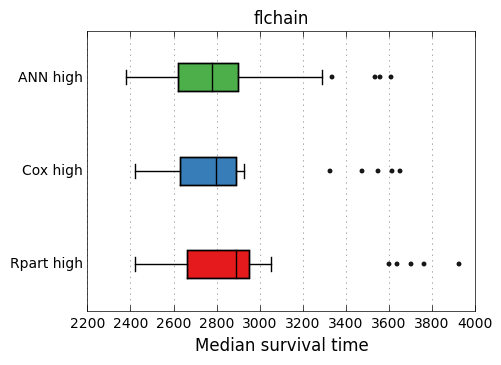

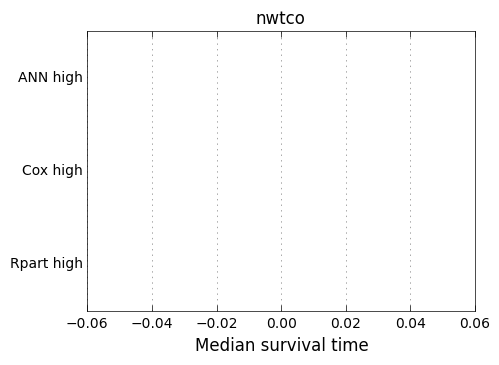

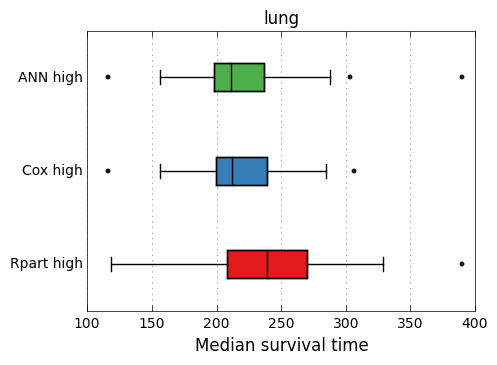

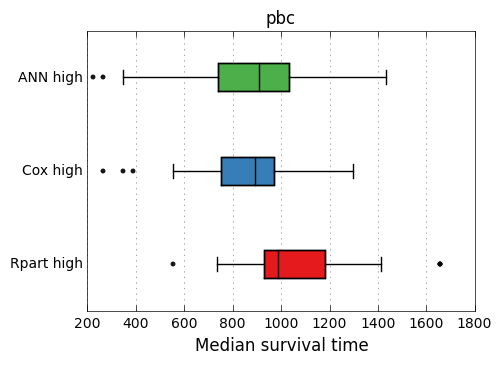

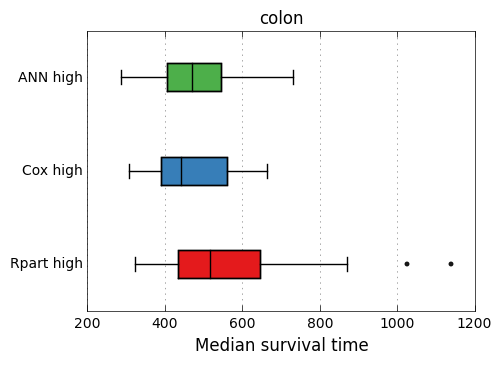

In [55]:
# Median survival
for dname, _df in datasets.items():
    labels = [n + " high" for n in ['Rpart', 'Cox', 'ANN']]
    
    rpart_box = []
    cox_box = []
    ann_box = []
    
    # Also keep track of when no median can be calculated
    ann_inf = 0
    cox_inf = 0
    rpart_inf = 0
    
    n = _df.shape[0]
        
    # For each repetition
    for rep in range(cross_n):
        # Should not have been a list...
        perm = data_permutations[dname][rep][0]
        
        duration_col = _df.columns[0]
        event_col = _df.columns[1]
        
        df = _df.reindex(perm).sort(event_col)
        
        assignments = np.array((n // cross_k + 1) * list(range(1, cross_k + 1)))
        assignments = assignments[:n]
            
        # For each division
        for i in range(1, cross_k + 1):
            ix = assignments == i
            training_data = df.ix[~ix]
            testing_data = df.ix[ix]
            
            T_actual = testing_data[duration_col].values
            E_actual = testing_data[event_col].values
            #X_testing = testing_data[testing_columns]
            
            # Calculate what of interest
            kmf = KaplanMeierFitter()
            
            ## Rpart
            rpart_preds = rpart_val_preds[dname][rep][i-1]
            members = (rpart_preds == 'high').values.ravel()
            
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            
            if np.isinf(kmf.median_):
                rpart_inf += 1
            else:
                rpart_box.append(kmf.median_)
            
            ## Cox
            cox_preds = cox_val_preds[dname][rep][i-1]
            members = (cox_preds == 'high').values.ravel()
            
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            
            if np.isinf(kmf.median_):
                cox_inf += 1
            else:
                cox_box.append(kmf.median_)
            
            ## ANN
            ann_preds = ann_val_preds[dname][rep][i-1]
            members = (ann_preds == 'high').values.ravel()
            
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            
            if np.isinf(kmf.median_):
                ann_inf += 1
            else:
                ann_box.append(kmf.median_)
                
    print("\n  ", dname)
    print("Rpart infs:", rpart_inf)
    print("Cox infs:", cox_inf)
    print("ANN infs:", ann_inf)

    plt.figure()
    #fig = plt.figure(figsize=(2.5, 2.0))
    plt.title(dname)
    plt.boxplot([rpart_box, cox_box, ann_box], 
                labels=labels, vert=False, colors=plt.colors[:3])
    plt.xlabel("Median survival time")
    savefig("crossval-{}-median".format(dname))

/home/gibson/jonask/anaconda3/envs/riskgroups/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


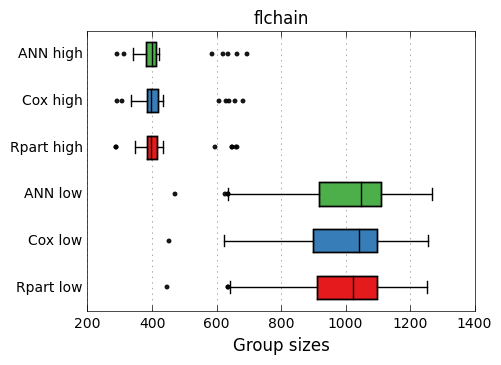

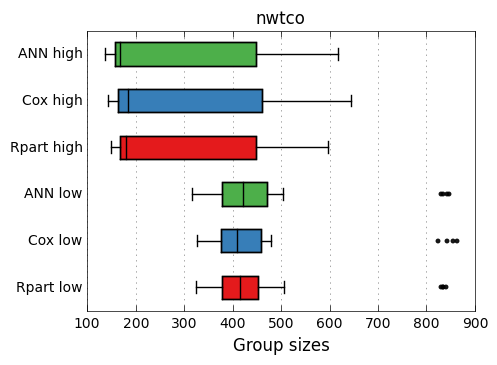

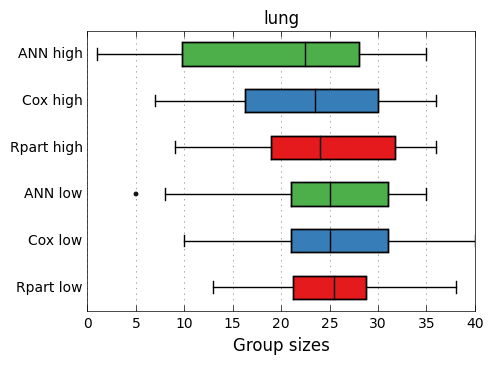

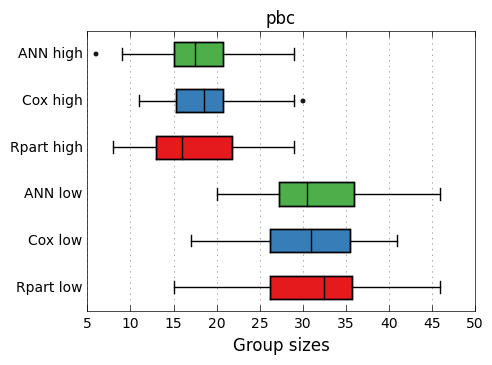

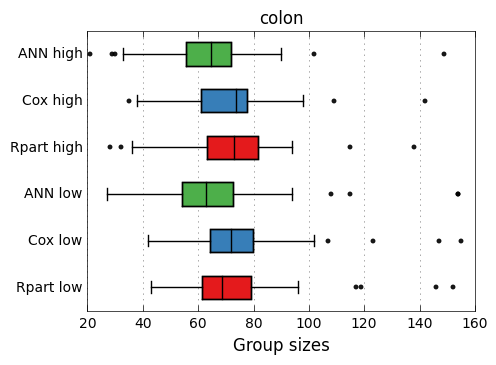

In [56]:
# Group sizes
for dname, _df in datasets.items():
    labels = [n + " low" for n in ['Rpart', 'Cox', 'ANN']]
    labels.extend([n + " high" for n in ['Rpart', 'Cox', 'ANN']])
    
    rpart_high_box, rpart_low_box = [], []
    cox_high_box, cox_low_box = [], []
    ann_high_box, ann_low_box = [], []
    
    n = _df.shape[0]
        
    # For each repetition
    for rep in range(cross_n):
        # Should not have been a list...
        perm = data_permutations[dname][rep][0]
        
        duration_col = _df.columns[0]
        event_col = _df.columns[1]
        
        df = _df.reindex(perm).sort(event_col)
        
        assignments = np.array((n // cross_k + 1) * list(range(1, cross_k + 1)))
        assignments = assignments[:n]
            
        # For each division
        for i in range(1, cross_k + 1):
            ix = assignments == i
            training_data = df.ix[~ix]
            testing_data = df.ix[ix]
            
            T_actual = testing_data[duration_col].values
            E_actual = testing_data[event_col].values
            #X_testing = testing_data[testing_columns]
            
            ## Rpart
            rpart_preds = rpart_val_preds[dname][rep][i-1]
            
            rpart_high_box.append(np.sum(rpart_preds == 'high'))
            rpart_low_box.append(np.sum(rpart_preds == 'low'))
            
            ## Cox
            cox_preds = cox_val_preds[dname][rep][i-1]
            
            cox_high_box.append(np.sum(cox_preds == 'high'))
            cox_low_box.append(np.sum(cox_preds == 'low'))
            
            ## ANN
            ann_preds = ann_val_preds[dname][rep][i-1]
            
            ann_high_box.append(np.sum(ann_preds == 'high'))
            ann_low_box.append(np.sum(ann_preds == 'low'))
            
    plt.figure()
    plt.title(dname)
    # Labels are ordered low-high
    plt.boxplot([rpart_low_box, cox_low_box, ann_low_box, rpart_high_box, cox_high_box, ann_high_box], 
                labels=labels, vert=False, colors=plt.colors[:3])
    plt.xlabel("Group sizes")
    savefig("crossval-{}-groupsize".format(dname))

/home/gibson/jonask/anaconda3/envs/riskgroups/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


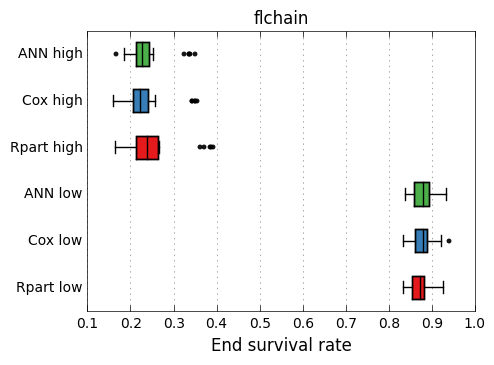

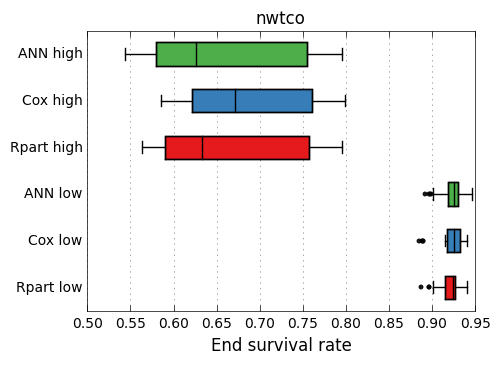

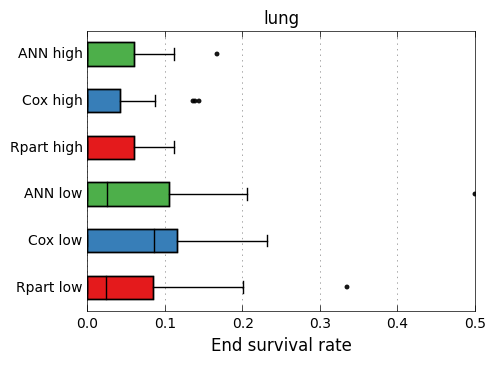

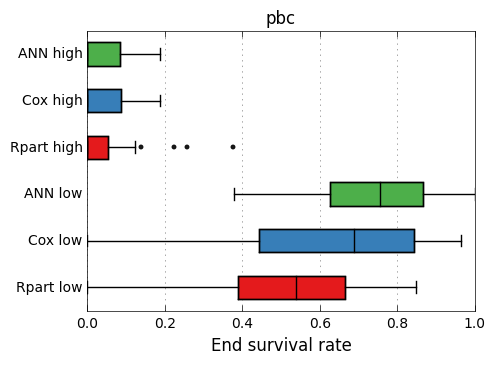

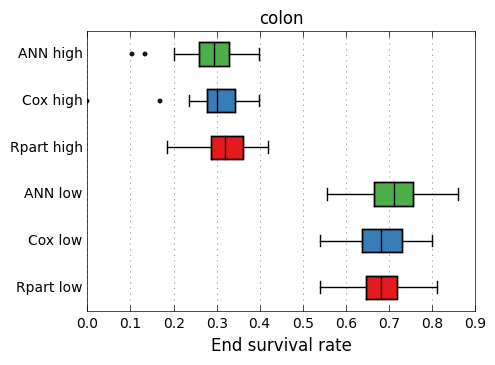

In [57]:
# End survival rate
for dname, _df in datasets.items():
    labels = [n + " low" for n in ['Rpart', 'Cox', 'ANN']]
    labels.extend([n + " high" for n in ['Rpart', 'Cox', 'ANN']])
    
    rpart_high_box, rpart_low_box = [], []
    cox_high_box, cox_low_box = [], []
    ann_high_box, ann_low_box = [], []
    
    n = _df.shape[0]
        
    # For each repetition
    for rep in range(cross_n):
        # Should not have been a list...
        perm = data_permutations[dname][rep][0]
        
        duration_col = _df.columns[0]
        event_col = _df.columns[1]
        
        df = _df.reindex(perm).sort(event_col)
        
        assignments = np.array((n // cross_k + 1) * list(range(1, cross_k + 1)))
        assignments = assignments[:n]
            
        # For each division
        for i in range(1, cross_k + 1):
            ix = assignments == i
            training_data = df.ix[~ix]
            testing_data = df.ix[ix]
            
            T_actual = testing_data[duration_col].values
            E_actual = testing_data[event_col].values
            #X_testing = testing_data[testing_columns]
            
            # Calculate what of interest
            kmf = KaplanMeierFitter()
            
            ## Rpart
            rpart_preds = rpart_val_preds[dname][rep][i-1]
            
            members = (rpart_preds == 'high').values.ravel()
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            rpart_high_box.append(kmf.survival_function_.iloc[-1, 0])
            
            members = (rpart_preds == 'low').values.ravel()
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            rpart_low_box.append(kmf.survival_function_.iloc[-1, 0])
            
            ## Cox
            cox_preds = cox_val_preds[dname][rep][i-1]
            
            members = (cox_preds == 'high').values.ravel()
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            cox_high_box.append(kmf.survival_function_.iloc[-1, 0])
            
            members = (cox_preds == 'low').values.ravel()
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            cox_low_box.append(kmf.survival_function_.iloc[-1, 0])
            
            ## ANN
            ann_preds = ann_val_preds[dname][rep][i-1]
            
            members = (ann_preds == 'high').values.ravel()
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            ann_high_box.append(kmf.survival_function_.iloc[-1, 0])
            
            members = (ann_preds == 'low').values.ravel()
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label=None)
            ann_low_box.append(kmf.survival_function_.iloc[-1, 0])
            
    plt.figure()
    plt.title(dname)
    # Labels are ordered low-high
    plt.boxplot([rpart_low_box, cox_low_box, ann_low_box, rpart_high_box, cox_high_box, ann_high_box], 
                labels=labels, vert=False, colors=plt.colors[:3])
    plt.xlabel("End survival rate")
    savefig("crossval-{}-endsurvrate".format(dname))